In [38]:
import os, sys, glob
import pickle
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
from matplotlib.lines import Line2D
import lightkurve as lk
from astropy.table import Table
import astropy.units as u

path = os.path.dirname(os.getcwd())
sys.path.append(path)
from kepler_apertures import KeplerFFI, KeplerPRF, EXBAMachine

# Figure 2

In [3]:
qu = 5
ch = 48
exba = EXBAMachine(quarter=qu, channel=ch, magnitude_limit=20, gaia_dr=3)

TargetPixelFileCollection of 4 objects:
    0: KeplerTargetPixelFile Object (ID: 100002295)
    1: KeplerTargetPixelFile Object (ID: 100002296)
    2: KeplerTargetPixelFile Object (ID: 100002297)
    3: KeplerTargetPixelFile Object (ID: 100002298)
Loading query from file...
/Users/jorgemarpa/Work/BAERI/ADAP/kepler-apertures/data/catalogs/exba/5/channel_48_gaiadr3_xmatch.csv


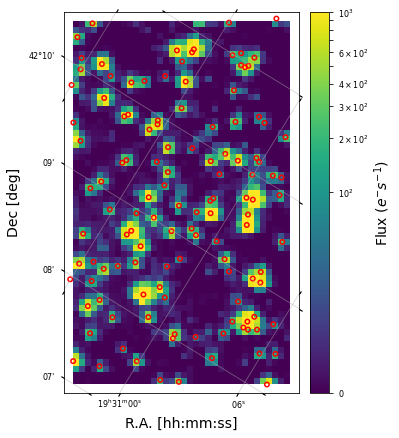

In [42]:
with plt.style.context('seaborn-paper'):
    ax = exba.plot_image()
    ax.set_title("")
    ax.set_xlim(exba.column.min()-2, exba.column.max()+2)
    ax.set_ylim(exba.row.min()-2, exba.row.max()+2)
    ax.grid(True, alpha=.5)

    plt.savefig("../data/figures/paper/EXBA_img_q%i_ch%02i.pdf" % (qu, ch), 
                format="pdf", bbox_inches="tight")
    plt.show()

# Figure 3

In [43]:
quarters = np.arange(5, 18)
channels = np.arange(1, 85)
channels = np.delete(channels, [4,5,6,7])

In [44]:
big_cat_path = "../data/catalogs/EXBA_catalog_all_sources.csv"
big_df = pd.read_csv(big_cat_path, index_col=0, header=[0, 1])

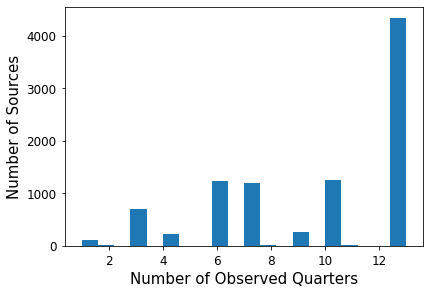

In [51]:
with plt.style.context('seaborn-paper'):
    plt.hist(np.isfinite(big_df.loc[:, ([str(q) for q in quarters], "channel")]).sum(axis=1).values, bins=20)
    plt.xlabel("Number of Observed Quarters", fontsize=15)
    plt.ylabel("Number of Sources", fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.savefig("../data/figures/paper/source_quarters.pdf", 
                format="pdf", bbox_inches="tight")
    
    plt.show()

# Figure 4

In [2]:
full_catalog = pd.read_csv("../data/catalogs/EXBA_catalog_all_sources_reduced.csv", index_col=0)

In [12]:
full_catalog.query("parallax < 0.01").shape, full_catalog.query("parallax < 0.1").shape

((1024, 23), (1712, 23))

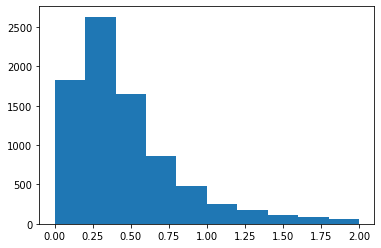

In [9]:
plt.hist(full_catalog.parallax, range=[0, 2]);

In [13]:
full_catalog["abs_gmag"] = (full_catalog.phot_g_mean_mag + 
                          5 * (np.log10(full_catalog.parallax/1e3) + 1))
full_catalog["abs_gmag_err"] = np.sqrt((2.5 * full_catalog.phot_g_mean_flux_error/ (full_catalog.phot_g_mean_flux * np.log(10))) ** 2 + (5 * full_catalog.parallax_error/(full_catalog.parallax * np.log(10))) ** 2)
full_catalog["distance"] = 1e3 / full_catalog.parallax
good_parallax = (full_catalog.parallax > 0.01) & (full_catalog['phot_rp_mean_mag'] < 100) & (full_catalog['phot_bp_mean_mag'] < 100)

In [14]:
g304 = ["Gaia EDR3 2077240046296834304"]
interesting = full_catalog.loc[g304]

In [52]:
((13 * u.au).to("pc") / (970* u.pc) * u.degree).to("mas")

<Quantity 0.23391011 mas>

In [36]:
interesting

,ra,ra_error,dec,dec_error,pmra,pmdec,parallax,parallax_error,phot_g_n_obs,phot_g_mean_flux,...,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,abs_gmag,abs_gmag_err,distance
Gaia EDR3 2077240046296834304,295.859493,0.132511,42.713193,0.142235,-1.99492,-9.407661,1.030341,0.155608,410.0,4345.644952,...,1716.888633,8.338573,17.251686,47.0,4357.314376,8.755736,15.649848,6.657137,0.327974,970.552522


In [15]:
kep_data = Table.read("../data/catalogs/kepler_edr3_4arcsec.fits", format="fits")
kep_data["abs_gmag"] = (kep_data['phot_g_mean_mag'] + 
                         5.*(np.log10(kep_data['parallax']/1.e3) + 1.))
good_parallax_kep = kep_data['parallax'] > 0.01

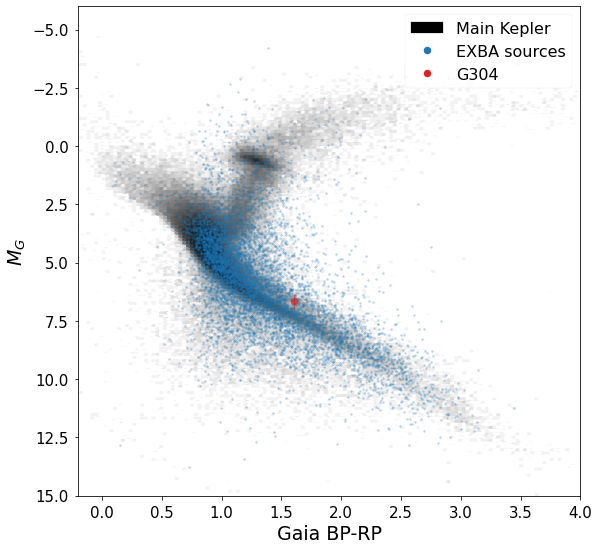

In [30]:
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1,1,figsize=(9,9))

    filter = (kep_data['phot_g_mean_mag'] <= 20.) & (kep_data['parallax'] > 0.1) & (np.isfinite(kep_data['bp_rp']))
    # ax.scatter(kep_data['bp_rp'][filter], kep_data['abs_gmag'][filter], 
    #            alpha=0.2, color='k', s=1, rasterized=True,
    #            label='Main Kepler')
    ax.hexbin(kep_data['bp_rp'][filter], kep_data['abs_gmag'][filter], cmap="Greys", 
              gridsize=250, bins="log", rasterized=True)
    # ax.hist2d(kep_data['bp_rp'][filter], kep_data['abs_gmag'][filter], cmap="Greys", 
    #           bins=[200, 200], density=True, norm=colors.LogNorm(), rasterized=True)
    # sb.kdeplot(data=kep_data_df[filter], x="bp_rp", y="abs_gmag", color="k", ax=ax)

    # filter2 = (kep_data['planet?'] == 'cand') & filter
    # ax.scatter(kep_data['bp_rp'][filter2], kep_data['abs_gmag'][filter2], 
    #            alpha=0.7, s=1, color='tab:red',
    #            label='Candidate host ({0})'.format(sum(filter2)))

    # EXBA
    ax.scatter(full_catalog['phot_bp_mean_mag'][good_parallax] - full_catalog['phot_rp_mean_mag'][good_parallax], 
               full_catalog['abs_gmag'][good_parallax], 
               alpha=0.3, s=4, color='tab:blue', rasterized=False)

    # filter2 = (kep_data['planet?'] == 'conf') & filter
    # ax.scatter(kep_data['bp_rp'][filter2], kep_data['abs_gmag'][filter2], 
    #            alpha=0.7, s=1, color='tab:blue',
    #            label='Confirmed host ({0})'.format(sum(filter2)))

    # interesting sources from EXBA
    ax.errorbar(interesting['phot_bp_mean_mag'] - interesting['phot_rp_mean_mag'], 
                interesting['abs_gmag'], 
                yerr=interesting['abs_gmag_err'],
                marker=".",
                alpha=0.7, color='tab:red',
                # label='G304',
                markersize=15)

    ax.set_xlabel('Gaia BP-RP', fontsize=19)
    ax.set_ylabel('$M_G$', fontsize=19)
    ax.set_ylim([15,-6])
    ax.set_xlim([-0.2,4])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    leg = [patches.Patch(color="black", label="Main Kepler"), 
           Line2D([0], [0], marker='.', color='w', label='EXBA sources', markerfacecolor='tab:blue', markersize=15),
           Line2D([0], [0], marker='.', color='w', label='G304', markerfacecolor='tab:red', markersize=15)]
    
    ax.legend(handles=leg, loc='upper right', fontsize=16, frameon=True)

    # plt.savefig("../data/figures/paper/cmd_exba.pdf", 
    #         format="pdf", bbox_inches="tight")
    plt.show()

# Figure 5

In [167]:
with open('../data/export/G304_proc_lcs.pkl', 'rb') as f:
    obj = pickle.load(f)
regcorr_nosp_llc = obj["regcorr_nosp_llc"]
regcorr_full_llc = obj["regcorr_full_llc"]
f_regcorr_full_etlc = obj["f_regcorr_full_etlc"]

In [168]:
for k in range(len(regcorr_full_llc)):
    regcorr_nosp_llc[k].primary_key = ('time',)
    regcorr_full_llc[k].primary_key = ('time',)
f_regcorr_full_etlc.primary_key = ('time',)

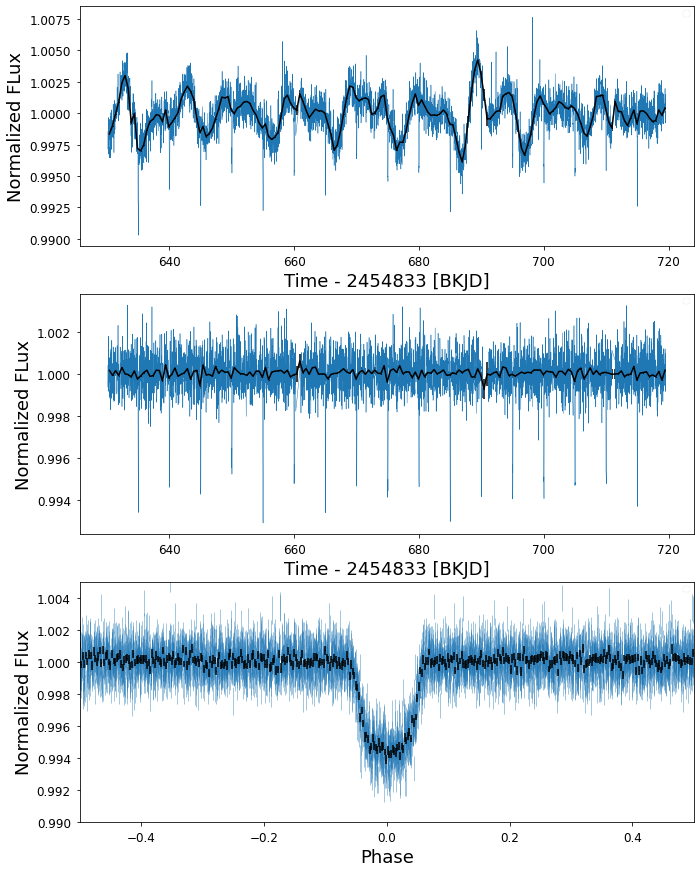

In [175]:
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(3,1, figsize=(11,15))
    
    regcorr_nosp_llc[4].plot(color="tab:blue", ax=ax[0], rasterized=True)
    regcorr_nosp_llc[4].bin(time_bin_size=0.5, aggregate_func=np.nanmedian).errorbar(
        ax=ax[0], alpha=1, lw=1.5, c='k', marker=".", ms=2)
    regcorr_nosp_llc[4].bin(time_bin_size=0.5, aggregate_func=np.nanmedian).plot(
        ax=ax[0], alpha=1, lw=1.5, c='k')
    ax[0].set_ylabel("Normalized FLux", fontsize=18)
    ax[0].set_xlabel("Time - 2454833 [BKJD]", fontsize=18)
    ax[0].legend("")
    ax[0].tick_params(axis='both', which='major', labelsize=12)
    
    regcorr_full_llc[4].remove_outliers(sigma_lower=1e10, sigma_upper=3).plot(color="tab:blue", ax=ax[1], rasterized=True)
    regcorr_full_llc[4].bin(time_bin_size=0.5, aggregate_func=np.nanmedian).errorbar(
        ax=ax[1], alpha=1, lw=1.5, c='k', marker=".", ms=2)
    regcorr_full_llc[4].bin(time_bin_size=0.5, aggregate_func=np.nanmedian).plot(
        ax=ax[1], alpha=1, lw=1.5, c='k')
    ax[1].set_ylabel("Normalized FLux", fontsize=18)
    ax[1].set_xlabel("Time - 2454833 [BKJD]", fontsize=18)
    ax[1].legend("")
    ax[1].tick_params(axis='both', which='major', labelsize=12)
    
    f_regcorr_full_etlc.errorbar(alpha=0.8, c="tab:blue", ax=ax[2], rasterized=True)
    f_regcorr_full_etlc.bin(bins=2000, aggregate_func=np.nanmedian).errorbar(
        ax=ax[2], alpha=1, lw=1.5, c='k', marker=".", ms=2)
    ax[2].set_xlim(-0.5, 0.5)
    ax[2].set_ylim(0.99, 1.005)
    ax[2].set_ylabel("Normalized Flux", fontsize=18)
    ax[2].set_xlabel("Phase", fontsize=18)
    ax[2].legend("")
    ax[2].tick_params(axis='both', which='major', labelsize=12)
    
    plt.savefig("../data/figures/paper/g304_lc.pdf", 
                format="pdf", bbox_inches="tight")
    
    plt.show()

# Figure 6

In [122]:
G304_tpf = lk.search_targetpixelfile("KIC 7214804",
                                      author="Kepler",
                                     quarter=7,
                                      cadence="long").download()
G304_tpf

KeplerTargetPixelFile Object (ID: 7214804)

In [123]:
G304_tpf.quarter

7

In [124]:
G304_col, G304_row = np.mgrid[G304_tpf.column : G304_tpf.column + G304_tpf.shape[2],
                              G304_tpf.row : G304_tpf.row + G304_tpf.shape[1]]

In [112]:
exba = EXBAMachine(quarter=7, channel=17, magnitude_limit=20, gaia_dr=3)

TargetPixelFileCollection of 4 objects:
    0: KeplerTargetPixelFile Object (ID: 100002955)
    1: KeplerTargetPixelFile Object (ID: 100002956)
    2: KeplerTargetPixelFile Object (ID: 100002957)
    3: KeplerTargetPixelFile Object (ID: 100002958)
Loading query from file...
/Users/jorgemarpa/Work/BAERI/ADAP/kepler-apertures/data/catalogs/exba/7/channel_17_gaiadr3_xmatch.csv


In [131]:
g304 = exba.sources.query("designation == 'Gaia EDR3 2077240046296834304'")

In [125]:
kic_col, kic_row = G304_tpf[idx].wcs.wcs_world2pix(G304_tpf[idx].meta["RA_OBJ"], G304_tpf[idx].meta["DEC_OBJ"], 0)
kic_col += G304_tpf[idx].column
kic_row += G304_tpf[idx].row

In [134]:
with open('../data/export/G304_contaminante_apertures.pkl', 'rb') as f:
    obj = pickle.load(f)
k804_ctm_ap = obj["k804_ctm_ap"]
g304_ctm_ap = obj["g304_ctm_ap"]

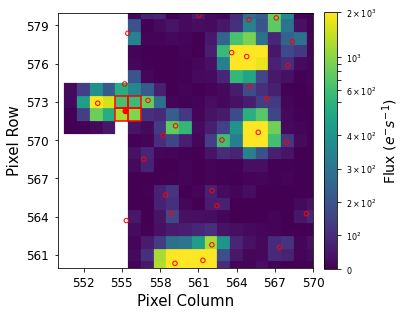

In [159]:
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1, figsize=(5, 7))
    # exba data
    pc = ax.scatter(exba.column_2d, exba.row_2d, c=exba.flux_2d[100].value, 
                marker="s", s=160, cmap="viridis", rasterized=False,
                norm=colors.SymLogNorm(linthresh=500, vmin=0, vmax=2000, base=10))
    # TPF data
    ax.scatter(G304_col.T, G304_row.T, c=G304_tpf[idx].flux[0].value, 
                marker="s", s=160, cmap="viridis", rasterized=False,
                norm=colors.SymLogNorm(linthresh=500, vmin=0, vmax=2000, base=10))
    
    cbar = fig.colorbar(pc, fraction=0.046, pad=0.04)
    cbar.set_label(label=r"Flux ($e^{-}s^{-1}$)", size=14)

    # EXBA gaia sources
    ax.scatter(
                    exba.sources.col,
                    exba.sources.row,
                    s=20,
                    facecolors="none",
                    marker="o",
                    edgecolors="r",
                    linewidth=1.,
                    label="Gaia Sources",
                )

    # G304
    ax.scatter(
                    g304.col,
                    g304.row,
                    s=20,
                    facecolors="r",
                    marker="o",
                    edgecolors="r",
                    linewidth=1.,
                    label="Gaia Sources",
                )
    # TPF targer
    ax.scatter(
                    kic_col,
                    kic_row,
                    s=20,
                    facecolors="none",
                    marker="o",
                    edgecolors="r",
                    linewidth=1.,
                    label="Gaia Sources",
                )
    # contaminante aperture from TPF
    for i in range(k804_ctm_ap[7].shape[0]):
        for j in range(k804_ctm_ap[7].shape[1]):
            if k804_ctm_ap[7][i, j]:
                rect = patches.Rectangle(
                    xy=(j + G304_tpf[idx].column - 0.5, i + G304_tpf[idx].row - 0.5),
                    width=1,
                    height=1,
                    color="red",
                    fill=False,
                    hatch="",
                    lw=1.5,
                )
                ax.add_patch(rect)
    # contaminante aperture from EXBA
    for i in range(g304_ctm_ap[7].shape[0]):
        for j in range(g304_ctm_ap[7].shape[1]):
            if g304_ctm_ap[7][i, j]:
                rect = patches.Rectangle(
                    xy=(j + exba.column.min() - 0.5, i + exba.row.min() - 0.5),
                    width=1,
                    height=1,
                    color="red",
                    fill=False,
                    hatch="",
                    lw=1.5,
                )
                ax.add_patch(rect)

    ax.set_aspect("equal", adjustable="box")
    ax.set_ylim(560, 580)
    ax.set_xlim(550, 570)

    ax.set_xlabel("Pixel Column", fontsize=15)
    ax.set_ylabel("Pixel Row", fontsize=15)
    ax.xaxis.set_major_locator(plt.MaxNLocator(7))
    ax.yaxis.set_major_locator(plt.MaxNLocator(7))
    ax.set_aspect("equal", adjustable="box")
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.savefig("../data/figures/paper/g304_img.pdf", 
            format="pdf", bbox_inches="tight")
    
    plt.show()
